In [1]:
import os
import re
import yaml
loader = yaml.SafeLoader
loader.add_implicit_resolver(
    u'tag:yaml.org,2002:float',
    re.compile(u'''^(?:
     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
    |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
    |\\.[0-9_]+(?:[eE][-+][0-9]+)?
    |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
    |[-+]?\\.(?:inf|Inf|INF)
    |\\.(?:nan|NaN|NAN))$''', re.X),
    list(u'-+0123456789.'))
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
from core.config import Config 
from core.testers import tester_entry 
# https://stackoverflow.com/questions/56395914/how-to-fix-error-while-loading-shared-libraries-libpython3-6m-so-1-0-cannot-o
# https://stackoverflow.com/questions/71759248/importerror-cannot-import-name-builder-from-google-protobuf-internal
from core import distributed_utils as dist
from core.distributed_utils import dist_init
from core.testers import tester_entry
from core.data.datasets.images.parsing_dataset import Human3M6ParsingDataset
import core.data.transforms.parsing_transforms as T

no mc
ceph can not be used
no mc
no mc
ceph can not be used
no mc
ceph can not be used


In [2]:
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return np.array(palette).reshape(-1,3)

class InferenceParsingDataset(Human3M6ParsingDataset):
    def __init__(self,
             data_paths,
             dataset='train',
             is_train=True,
             cfg=None,
             **kwargs):
        """human3.6m dataset for human parsing
        Args:
            root_dir ([str]): where dataset
            dataset: train / val
            cfg: yaml format config
        """
        # self.task_name = 'human3m6_parsing'
        self.cfg = cfg
        self.dataset = dataset
        self.is_train = is_train

        self.pseudo_labels = True

        self.img_list = data_paths

        self.images = self.img_list
        self.ignore_label = cfg.ignore_value
        self.num = len(self.images)
        self.num_classes = len(self.cfg.label_list)  # - 1
        assert self.num_classes == self.cfg.num_classes, f"num of class mismatch, len(label_list)={self.num_classes}, num_classes:{self.cfg.num_classes}"

        self.rank = dist.get_rank()
        self.world_size = dist.get_world_size()

        self.original_label = np.array(self.cfg.label_list)

        self.augs = T.compose([T.resize_image_eval(cfg.eval_crop_size),
                              T.transpose()])
        print(f"-- Loading {dataset} dataset of {len(data_paths)} images")
    
    def __getitem__(self, index):
        dataset_dict = {}
        img_path = self.img_list[index]
        dataset_dict["filename"] = os.path.basename(img_path)
        
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        parsing_seg_gt = np.zeros_like(image)

        self._record_image_size(dataset_dict, image)

        if self.pseudo_labels:
            image, parsing_seg_gt = self.augs(image, parsing_seg_gt)
            image = torch.as_tensor(np.ascontiguousarray(image))
            dataset_dict["image"] = image
            return dataset_dict

# run inference

In [3]:
dist_initialize = False

In [4]:
gpu = 2

# image_path = 'output/test_data/bikini_set/ou (6).png'
# image_path = "/media/hdd2/james/TryonTrainingImageProcessing/test_data/farfetch/tophalf_20266288_50422787_1000.jpg"
# data_paths = [image_path]

In [5]:
# parameter from the test script
which_model = "CIHP" # UniHCP finetuned on which dataset

if which_model == "Human3M6":
    TASK="par_lpe"  # Human3M6ParsingDataset
    GINFO_INDEX="1"   # task index config cherrypick (if necessary)
    save_name = "UniHCP-Human3M6"
elif which_model == "LIP":
    TASK="par_lip_lpe"
    GINFO_INDEX="3"
    save_name = "UniHCP-LIP"
elif which_model == "CIHP":
    TASK="par_cihp_lpe"
    GINFO_INDEX="4"
    save_name = "UniHCP-CIHP"
    """
    map for CIHP:
    {
    1:'hat'
    2:'hair',
    4:'sunglasses',
    5:'upperclothes',
    6:'dress',
    7:'coat',
    9:'pants',
    10:'torsoSkin',
    12:'skirt',
    13:'face',
    14:'leftArm',
    15:'rightArm',
    16:'leftLeg',
    17:'rightLeg',
    18:'leftShoe',
    19:'rightShoe'
    }
    
    """
elif which_model == "DeepFashion":
    TASK="par_deepfashion_lpe"
    GINFO_INDEX="21"
    save_name = "UniHCP-DeepFashion"
elif which_model == "VIP":
    TASK="par_vip_lpe"
    GINFO_INDEX="22"
    save_name = "UniHCP-VIP"
elif which_model == "ModaNet":
    TASK="par_modanet_lpe"
    GINFO_INDEX="23"
    save_name = "UniHCP-ModaNet"
else:
    raise ValueError("Unknown model")
    
################### ||| additional params usually not used
job_name='coslr1e3_104k_b4324g88_h256_I2k_1_10_001_2I_fairscale_m256'  #${4-debug}
CONFIG_BASE = "experiments/unihcp/release"
PRETRAIN_JOB_NAME=job_name #${6-${job_name}}
CONFIG=f"{CONFIG_BASE}/{job_name}.yaml"
TEST_CONFIG=f"{CONFIG_BASE}/vd_{TASK}_test.yaml"
TEST_MODEL=f"checkpoints/{PRETRAIN_JOB_NAME}/ckpt_task{GINFO_INDEX}_iter_newest.pth.tar"

assert os.path.isfile(CONFIG)
assert os.path.isfile(TEST_CONFIG)

In [6]:
from argparse import Namespace
args = Namespace(
    expname=f"test_{TASK}",
    config=CONFIG,
    test_config=TEST_CONFIG,
    spec_ginfo_index=int(GINFO_INDEX),
    load_path=TEST_MODEL,
    load_single=False,
    auto_resume=None,
    recover=False,
    ignore=[]
)
args

Namespace(auto_resume=None, config='experiments/unihcp/release/coslr1e3_104k_b4324g88_h256_I2k_1_10_001_2I_fairscale_m256.yaml', expname='test_par_cihp_lpe', ignore=[], load_path='checkpoints/coslr1e3_104k_b4324g88_h256_I2k_1_10_001_2I_fairscale_m256/ckpt_task4_iter_newest.pth.tar', load_single=False, recover=False, spec_ginfo_index=4, test_config='experiments/unihcp/release/vd_par_cihp_lpe_test.yaml')

In [7]:
if not dist_initialize:
    dist_init(gpu=gpu)
    dist_initialize = True

In [8]:
# load config
C_train = Config(args.config, spec_ginfo_index=args.spec_ginfo_index)
print("----------------------")

with open(args.test_config) as f:
    test_config = yaml.load(f, Loader=loader)
num_test_tasks = len(test_config['tasks'])
assert num_test_tasks == 1, "One task/dataset"

test_spec_ginfo_index = 0
C_test = Config(args.test_config, spec_ginfo_index=test_spec_ginfo_index)
if args.expname is not None:
    C_train.config['expname'] = args.expname
print("----------------------")

[rank 0] >> task_info.group[0] ranks [0]
[rank 0] >> task_info.root_group ranks [0]
[rank 0] >> task_info.backbone_share_group[[0]] ranks [0]
[rank 0] >> task_info.neck_share_group[[0]] ranks [0]
[rank 0] >> task_info.decoder_share_group[[0]] ranks [0]
[rank 0] backbone of task0 has been overided to {'type': 'vit_base_patch16', 'kwargs': {'task_sp_list': ['rel_pos_h', 'rel_pos_w'], 'pretrained': True, 'lms_checkpoint_train': 'fairscale', 'window': False, 'test_pos_mode': 'learnable_interpolate', 'learnable_pos': True, 'drop_path_rate': 0.2, 'img_size': 1344}}
[rank 0] decoder of task0 has been overided to {'type': 'AIOHead', 'kwargs': {'task': 'par_bce_cls_emb', 'task_sp_list': ['loss.', 'predictor.query_feat', 'predictor.query_embed'], 'loss_weight': 1.0, 'transformer_predictor_cfg': {'hidden_dim': 256, 'num_queries': 20, 'nheads': 8, 'dim_feedforward': 2048, 'dec_layers': 9, 'pre_norm': False, 'arch': 'fan_in', 'enforce_input_project': False, 'mask_on': False, 'num_feature_levels': 1

In [9]:
# load manager
S = tester_entry(C_train, C_test)

sync_print: rank 0, override tensor.cuda() to preserve task_specific flag


[2023-08-21 13:37:41,680][solver_multitask_dev.py][line: 661][    INFO] deterministic mode, seed: 233, worker_rank: True,                                   cudnn_deterministic: False
INFO:global_logger:deterministic mode, seed: 233, worker_rank: True,                                   cudnn_deterministic: False


## Select image dir

In [19]:
image_dir = "ip_data/test_data/test_sample"
# image_dir = "ip_data/test_data/ssense"
# image_dir = "ip_data/test_data/farfetch"
# image_dir = "ip_data/test_data/wild"

save_raw = False
# save_raw = True

data_paths = [os.path.join(image_dir, img_fn) for img_fn in os.listdir(image_dir) 
              if os.path.splitext(img_fn)[1] in [".jpg", ".png", ".jpeg"]]
test_set_name = os.path.basename(image_dir)
if not save_raw:
    save_dir = f"ip_data/results/{save_name}/{test_set_name}"
else:
    save_dir = f"ip_data/results/{save_name}/{test_set_name}_raw"
os.makedirs(save_dir, exist_ok=True)
print("Save to", save_dir)

Save to ip_data/results/UniHCP-CIHP/test_sample


In [20]:
# load data
S.config.dataset.kwargs.ginfo = S.ginfo
S.dataset = InferenceParsingDataset(data_paths=data_paths, **S.config.dataset["kwargs"])
dist.barrier()

-- Loading val dataset of 2 images


In [21]:
# load model
S.create_model()
print("-- Load checkpoint")
S.load_args = args
S.load(args);

[rank 0] Position interpolate from (14, 14) to (84, 84)
Missing keys: []

finish load
sync_print: rank 0, Number of conv/bn params: 0.59M
sync_print: rank 0, Number of linear params: 85.02M
aio_entry_v2(
  (backbone_module): ViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block

[rank 0] Recovering from checkpoints/coslr1e3_104k_b4324g88_h256_I2k_1_10_001_2I_fairscale_m256/ckpt_task4_iter_newest.pth.tar, keys=['step', 'state_dict', 'optimizer']
[rank 0] ======= loading model state for task 0 ... =======
[rank 0] load msg: <All keys matched successfully>


In [24]:
# inference
S.create_dataloader()
palette = get_palette(S.dataset.num_classes)

S.model.eval()
with torch.no_grad():
    for idx, S.tmp.input in tqdm(enumerate(S.test_loader), total=len(S.test_loader)):
        S.prepare_data()
        outputs = S.model(S.tmp.input_var, idx)
        torch.cuda.synchronize()
        
        for i, output in enumerate(outputs):
            par_pred = output["sem_seg"]
            output = par_pred.argmax(dim=0).cpu()
            pred = np.array(output, dtype=np.int)
            img_name = S.tmp.input_var["filename"][i]
            save_path = os.path.join(save_dir, os.path.splitext(img_name)[0]+"-.png")
            if save_raw:
                cv2.imwrite(save_path, pred)
            else:
#                 cv2.imwrite(save_path, palette[pred])
                cv2.imwrite(save_path, cv2.cvtColor(palette[pred].astype(np.uint8), cv2.COLOR_RGB2BGR))
print("Save to", save_dir)

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

Save to ip_data/results/UniHCP-CIHP/test_sample


In [14]:
par_pred = outputs[0]["sem_seg"]
output = par_pred.argmax(dim=0).cpu()
pred = np.array(output, dtype=np.int)
pred.shape

(1334, 1000)

In [15]:
S.tmp.input_var["image"][0].shape

torch.Size([3, 480, 480])

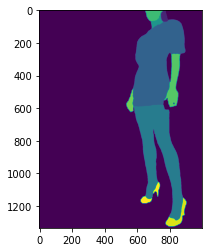

In [17]:
plt.imshow(pred)
plt.show()

In [20]:
np.unique(pred)

array([ 0,  2,  6,  8, 10, 13, 14, 15, 18, 19])

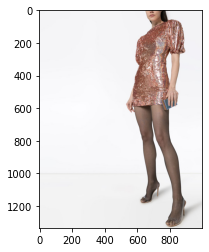

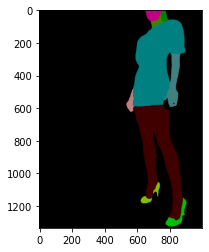

In [16]:
img_path = os.path.join(image_dir, S.tmp.input_var["filename"][0])
plt.imshow(plt.imread(img_path))
plt.show()
plt.imshow(palette[pred])
plt.show()